라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 3
model_name = 'Test230725_tank3_lstm_crop720_only-feed'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [7]:
japonica_training_features_X = japonica_training_data[['feed_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [8]:
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_X_chunks = japonica_training_features_X_chunks.reshape((-1, 720, 1))
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)
japonica_training_features_y_chunks = japonica_training_features_y_chunks.reshape((-1, 720, 1))

japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_X_chunks = japonica_validation_features_X_chunks.reshape((-1, 720, 1))
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)
japonica_validation_features_y_chunks = japonica_validation_features_y_chunks.reshape((-1, 720, 1))

In [9]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 90 nVar: 1
nCar: 90 nVar: 720
nCar: 90 nVar: 1
nCar: 90 nVar: 720


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [10]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(720, 1), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(720, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks, japonica_training_features_y_chunks, epochs = 1000, batch_size = 32, validation_data=(japonica_validation_features_X_chunks, japonica_validation_features_y_chunks), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-07-24 16:25:30.316318: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 16:25:30.944970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 128)          66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 720, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 720)               23760     
Total params: 152,144
Trainable params: 152,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000


2023-07-24 16:25:31.795422: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-24 16:25:35.973488: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-24 16:25:36.876818: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 7s 630ms/step - loss: 73.6874 - mae: 8.3444 - r_squared: -17.3836 - val_loss: 73.6322 - val_mae: 8.3411 - val_r_squared: -22.7012
Epoch 2/1000
3/3 [==============================] - 0s 155ms/step - loss: 73.5871 - mae: 8.3383 - r_squared: -20.9495 - val_loss: 73.4186 - val_mae: 8.3282 - val_r_squared: -22.6302
Epoch 3/1000
3/3 [==============================] - 0s 196ms/step - loss: 73.2107 - mae: 8.3157 - r_squared: -20.2771 - val_loss: 72.3942 - val_mae: 8.2659 - val_r_squared: -22.2897
Epoch 4/1000
3/3 [==============================] - 0s 200ms/step - loss: 71.8242 - mae: 8.2315 - r_squared: -19.5724 - val_loss: 70.9161 - val_mae: 8.1752 - val_r_squared: -21.7986
Epoch 5/1000
3/3 [==============================] - 0s 154ms/step - loss: 70.5375 - mae: 8.1509 - r_squared: -19.8993 - val_loss: 69.6012 - val_mae: 8.0941 - val_r_squared: -21.3617
Epoch 6/1000
3/3 [==============================] - 0s 147ms/step - loss: 69.1441 - mae: 8.0653 - r_squ

3/3 [==============================] - 0s 204ms/step - loss: 18.9107 - mae: 3.8600 - r_squared: -3.7244 - val_loss: 18.5078 - val_mae: 3.8092 - val_r_squared: -4.5579
Epoch 47/1000
3/3 [==============================] - 0s 198ms/step - loss: 18.3366 - mae: 3.7862 - r_squared: -3.8959 - val_loss: 17.9339 - val_mae: 3.7356 - val_r_squared: -4.3734
Epoch 48/1000
3/3 [==============================] - 0s 183ms/step - loss: 17.7600 - mae: 3.7126 - r_squared: -3.4600 - val_loss: 17.3828 - val_mae: 3.6637 - val_r_squared: -4.1964
Epoch 49/1000
3/3 [==============================] - 0s 201ms/step - loss: 17.2172 - mae: 3.6422 - r_squared: -3.2559 - val_loss: 16.8516 - val_mae: 3.5935 - val_r_squared: -4.0260
Epoch 50/1000
3/3 [==============================] - 0s 186ms/step - loss: 16.6914 - mae: 3.5714 - r_squared: -3.2445 - val_loss: 16.3365 - val_mae: 3.5243 - val_r_squared: -3.8610
Epoch 51/1000
3/3 [==============================] - 0s 204ms/step - loss: 16.1788 - mae: 3.5034 - r_squared:

3/3 [==============================] - 0s 175ms/step - loss: 5.8556 - mae: 1.7926 - r_squared: -0.4497 - val_loss: 5.7846 - val_mae: 1.7785 - val_r_squared: -0.5821
Epoch 92/1000
3/3 [==============================] - 0s 188ms/step - loss: 5.7504 - mae: 1.7712 - r_squared: -0.6452 - val_loss: 5.6901 - val_mae: 1.7591 - val_r_squared: -0.5550
Epoch 93/1000
3/3 [==============================] - 1s 212ms/step - loss: 5.6653 - mae: 1.7538 - r_squared: -0.4397 - val_loss: 5.5974 - val_mae: 1.7399 - val_r_squared: -0.5286
Epoch 94/1000
3/3 [==============================] - 1s 214ms/step - loss: 5.5718 - mae: 1.7343 - r_squared: -0.4229 - val_loss: 5.5099 - val_mae: 1.7217 - val_r_squared: -0.5038
Epoch 95/1000
3/3 [==============================] - 0s 191ms/step - loss: 5.4886 - mae: 1.7166 - r_squared: -0.3530 - val_loss: 5.4263 - val_mae: 1.7042 - val_r_squared: -0.4803
Epoch 96/1000
3/3 [==============================] - 0s 189ms/step - loss: 5.4035 - mae: 1.6989 - r_squared: -0.3712 - 

Epoch 137/1000
3/3 [==============================] - 0s 198ms/step - loss: 4.0107 - mae: 1.3891 - r_squared: 0.0133 - val_loss: 4.0050 - val_mae: 1.3879 - val_r_squared: -0.1269
Epoch 138/1000
3/3 [==============================] - 0s 188ms/step - loss: 4.0011 - mae: 1.3869 - r_squared: -0.0143 - val_loss: 3.9965 - val_mae: 1.3861 - val_r_squared: -0.1258
Epoch 139/1000
3/3 [==============================] - 0s 152ms/step - loss: 3.9926 - mae: 1.3855 - r_squared: 0.0205 - val_loss: 3.9885 - val_mae: 1.3845 - val_r_squared: -0.1248
Epoch 140/1000
3/3 [==============================] - 0s 195ms/step - loss: 3.9868 - mae: 1.3840 - r_squared: 0.0202 - val_loss: 3.9806 - val_mae: 1.3828 - val_r_squared: -0.1238
Epoch 141/1000
3/3 [==============================] - 0s 193ms/step - loss: 3.9779 - mae: 1.3823 - r_squared: 0.0276 - val_loss: 3.9736 - val_mae: 1.3814 - val_r_squared: -0.1230
Epoch 142/1000
3/3 [==============================] - 0s 184ms/step - loss: 3.9717 - mae: 1.3810 - r_squ

Epoch 183/1000
3/3 [==============================] - 0s 194ms/step - loss: 3.8777 - mae: 1.3649 - r_squared: 0.0411 - val_loss: 3.8775 - val_mae: 1.3649 - val_r_squared: -0.1257
Epoch 184/1000
3/3 [==============================] - 0s 204ms/step - loss: 3.8776 - mae: 1.3648 - r_squared: 0.0279 - val_loss: 3.8771 - val_mae: 1.3648 - val_r_squared: -0.1260
Epoch 185/1000
3/3 [==============================] - 0s 152ms/step - loss: 3.8773 - mae: 1.3649 - r_squared: 0.0351 - val_loss: 3.8768 - val_mae: 1.3648 - val_r_squared: -0.1262
Epoch 186/1000
3/3 [==============================] - 0s 148ms/step - loss: 3.8767 - mae: 1.3648 - r_squared: 0.0448 - val_loss: 3.8765 - val_mae: 1.3648 - val_r_squared: -0.1264
Epoch 187/1000
3/3 [==============================] - 0s 184ms/step - loss: 3.8765 - mae: 1.3648 - r_squared: 0.0436 - val_loss: 3.8762 - val_mae: 1.3648 - val_r_squared: -0.1267
Epoch 188/1000
3/3 [==============================] - 0s 150ms/step - loss: 3.8761 - mae: 1.3649 - r_squa

3/3 [==============================] - 0s 157ms/step - loss: 3.8727 - mae: 1.3652 - r_squared: 0.0316 - val_loss: 3.8727 - val_mae: 1.3652 - val_r_squared: -0.1317
Epoch 228/1000
3/3 [==============================] - 0s 158ms/step - loss: 3.8727 - mae: 1.3652 - r_squared: 0.0272 - val_loss: 3.8727 - val_mae: 1.3652 - val_r_squared: -0.1317
Epoch 229/1000
3/3 [==============================] - 0s 166ms/step - loss: 3.8727 - mae: 1.3652 - r_squared: 0.0449 - val_loss: 3.8727 - val_mae: 1.3652 - val_r_squared: -0.1317

Epoch 00229: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 230/1000
3/3 [==============================] - 0s 170ms/step - loss: 3.8727 - mae: 1.3652 - r_squared: 0.0537 - val_loss: 3.8727 - val_mae: 1.3652 - val_r_squared: -0.1317
Epoch 231/1000
3/3 [==============================] - 0s 182ms/step - loss: 3.8727 - mae: 1.3652 - r_squared: 0.0423 - val_loss: 3.8727 - val_mae: 1.3652 - val_r_squared: -0.1317
Epoch 232/1000
3/3 [==================

모델 평가

In [11]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [12]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 2.44715046e-02  9.45524424e-02 -5.03826067e-02 -7.89582953e-02
  -9.00379866e-02  3.80111597e-02 -3.63918357e-02 -8.31454322e-02
   4.42243889e-02 -5.49266599e-02  4.86180894e-02  1.07128799e-01
   5.29026277e-02  6.21380135e-02 -3.14141177e-02 -8.32689703e-02
  -4.61245999e-02 -3.24639827e-02 -9.01350677e-02  6.17260262e-02
   2.03749817e-02  1.03279591e-01 -2.74067130e-02 -6.92749470e-02
   7.42627382e-02 -7.62358457e-02  9.94647816e-02  2.55526900e-02
   4.22756448e-02  9.82988328e-02 -1.94291826e-02  3.70356217e-02
   8.78994986e-02  2.34190171e-04  3.71121019e-02  5.75261889e-03
  -1.65066123e-02 -4.03210223e-02  8.74445736e-02 -2.58153826e-02
   6.55705929e-02  3.13826054e-02 -8.54172111e-02 -8.19933787e-02
  -9.03039575e-02 -8.97519942e-03  4.48017468e-04  8.37210193e-02
   5.14406450e-02  1.88389514e-02 -8.66801813e-02 -1.37947267e-03
   6.81779608e-02 -1.73161644e-02  7.60506690e-02 -3.19440775e-02
   6.58671558e-02  3.67504284e-02 -1.46303074e-02  9.88702849e-02
   2.11301

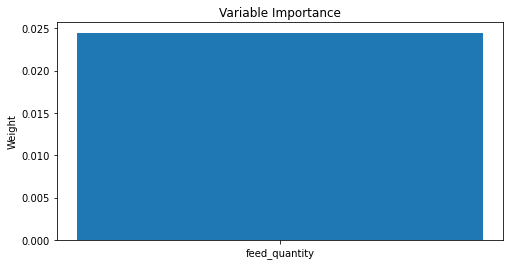

In [13]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(1), weights[:, 0])
ax.set_xticks(range(1))
ax.set_xticklabels(['feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [14]:
japonica_validation_features_X

,feed_quantity
mea_dt,
2021-07-21 00:00:00,0.0
2021-07-21 00:01:00,0.0
2021-07-21 00:02:00,0.0
2021-07-21 00:03:00,0.0
2021-07-21 00:04:00,0.0
...,...
2021-09-08 23:55:00,0.0
2021-09-08 23:56:00,0.0
2021-09-08 23:57:00,0.0


In [15]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 90 nVar: 1


In [16]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1
nCar: 90 nVar: 720


64800


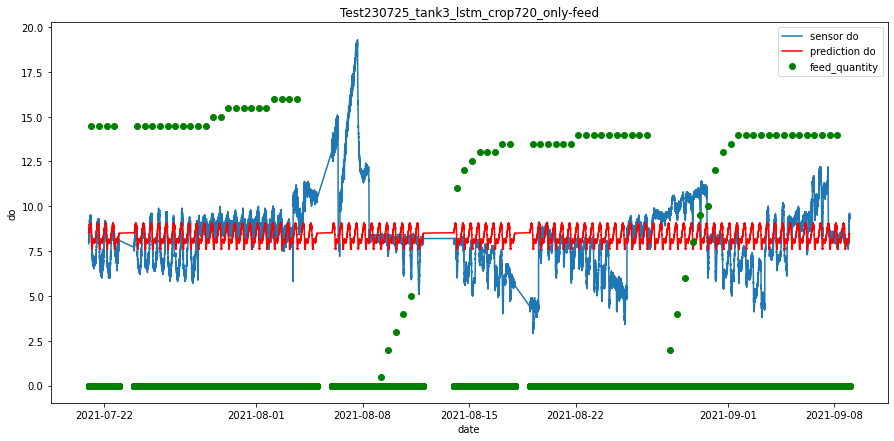

3/3 [==============================] - 1s 38ms/step - loss: 3.8727 - mae: 1.3652 - r_squared: -0.1317
MSE // MAE // R-squared  [3.8726744651794434, 1.3652327060699463, -0.13165442645549774]


In [17]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [18]:
X = japonica_validation_data.loc['2021-08-02 00:00':'2021-08-03 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 1


In [19]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 2880 nVar: 1
nCar: 4 nVar: 720


2880


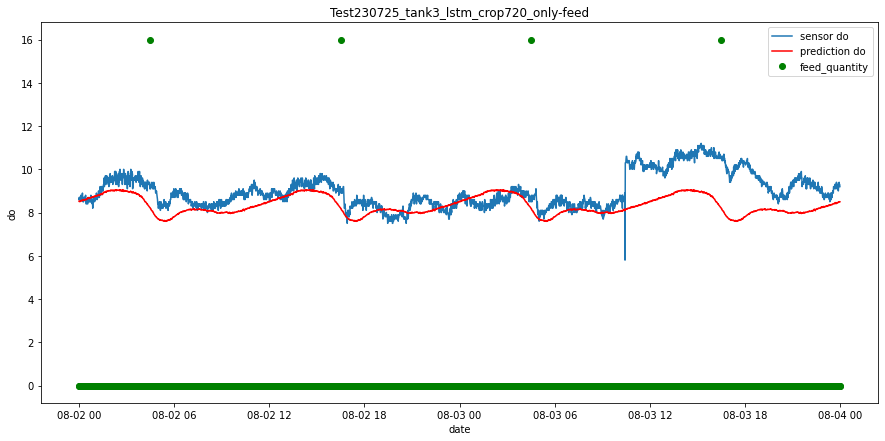

1/1 [==============================] - 0s 85ms/step - loss: 0.9769 - mae: 0.7590 - r_squared: -0.6080
MSE // MAE // R-squared  [0.9768649339675903, 0.7589908838272095, -0.6080021858215332]


In [20]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [21]:
X = japonica_validation_data.loc['2021-08-01 00:00':'2021-08-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14 nVar: 1


In [22]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 10080 nVar: 1
nCar: 14 nVar: 720


10080


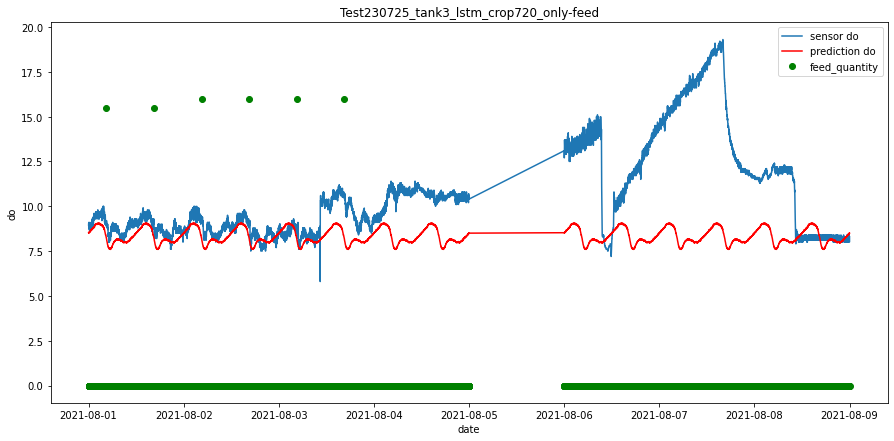

1/1 [==============================] - 0s 71ms/step - loss: 12.9296 - mae: 2.4612 - r_squared: -0.7949
MSE // MAE // R-squared  [12.929573059082031, 2.461155652999878, -0.7948988676071167]


In [23]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [24]:
X = japonica_validation_data.loc['2021-08-03 00:00':'2021-08-03 11:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1 nVar: 1


In [25]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 1 nVar: 720


720


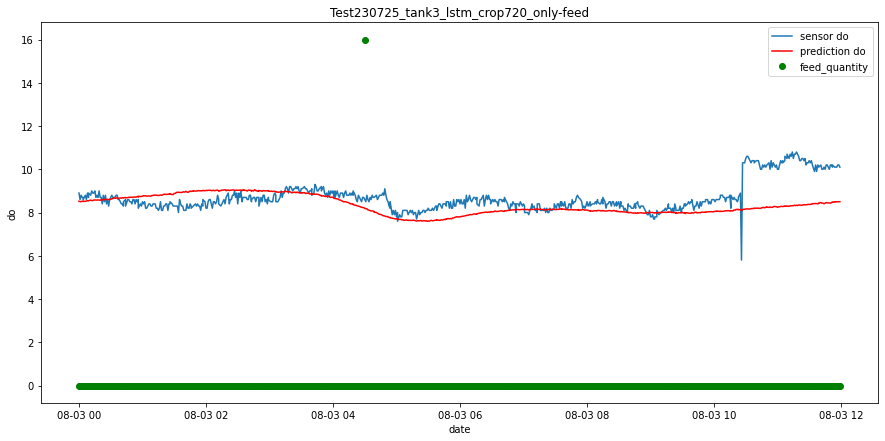

1/1 [==============================] - 0s 69ms/step - loss: 0.6859 - mae: 0.5848 - r_squared: -0.4534
MSE // MAE // R-squared  [0.6858872175216675, 0.5848448872566223, -0.45336055755615234]


In [26]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

nCar: 1 nVar: 1
nCar: 720 nVar: 1
nCar: 1 nVar: 720
720


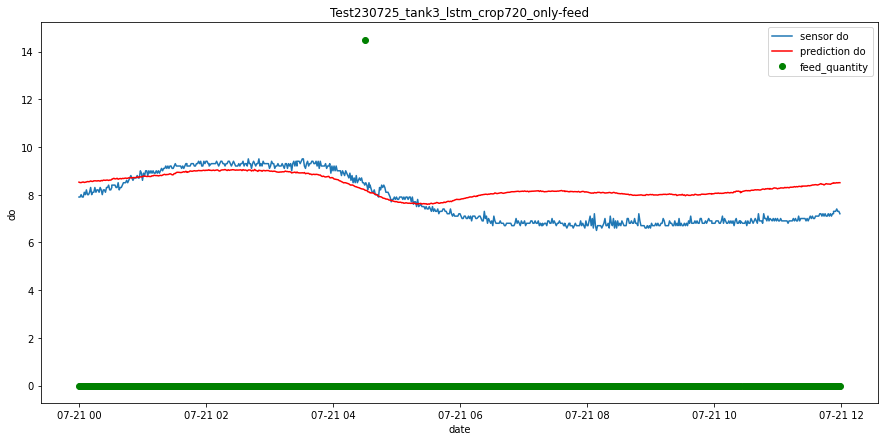

1/1 [==============================] - 0s 87ms/step - loss: 0.8486 - mae: 0.7727 - r_squared: 0.1927
MSE // MAE // R-squared  [0.8486157059669495, 0.7726998329162598, 0.192702054977417]


In [27]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-21 11:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)